In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from csv import reader
import os
import re
import spectral
from scipy.signal import argrelextrema
from scipy.ndimage import median_filter
from pysptools.spectro import convex_hull_removal
import spectral.io.envi as envi
import pickle

In [4]:
#define function to get wavelegnth list and I/F ratioed spectra from a give .tab file
def getMineralSpectra(tabFileAddress):
    #open the file
    tabFile=open(tabFileAddress,'r')
    #create csv read for the file
    fileReader=reader(tabFile)
    #create a list to hold the spectra of the current mineral
    mineralSpectra=[]
    #create a list to hold the wavelength list
    wavelengthList=[]
    #iterate over reach row
    for currentRow in fileReader:
        #add the channel wavelength to the wavelengthList
        wavelengthList.append(float(currentRow[0]))
        #add the I/F of the channel to the spectra
        mineralSpectra.append(float(currentRow[1]))
    #close the file
    tabFile.close()
    #convert the lists to numpy arrays and return
    return np.array(wavelengthList),np.array(mineralSpectra)

In [5]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [6]:
#create a list to hold mica wavelengthList
micaWavelengthList=[]
#create a list to hold spectra
allMICASpectras=[]
#set minerals of interest
mineralsOfInterest=["Chlorite",
                    "Serpentine"]
#iterate over minerals of interest
for currentMineral in mineralsOfInterest:
    #create a variable to hold the address of the file corresponding to the current mineral
    fileAddress=""
    
    #get the file for the current mineral
    for currentFile in allFiles:
        #check if the current current file is for the current mineral
        if currentMineral.lower() in currentFile:
            #read the file
            fileAddress=micaSpectraDirectory+"/"+currentFile
            break
    #get the wavelengths of the bands and the mineral spectra
    wavelengthList,currentMineralSpectra=getMineralSpectra(fileAddress)
    #get starting and ending points for spectra
    startIndex=find_nearest_index(wavelengthList,1.0)
    endIndex=find_nearest_index(wavelengthList,2.62)
    #subset the spectra and wavelengthList
    wavelengthList=wavelengthList[startIndex:endIndex]
    currentMineralSpectra=currentMineralSpectra[startIndex:endIndex]
    #add the spectra to the list
    allMICASpectras.append(currentMineralSpectra)
    #update MICA wavelength list
    micaWavelengthList=wavelengthList

In [7]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths():
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    #read wavelengths from saved wavelength file
    wavelengthsOfCurrentObservation=[]
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return wavelengthsOfCurrentObservation

In [69]:
#given a spectrum scale it between 0 and 1
def scaleSpectrum(spectrum):
    return (spectrum-np.amin(spectrum))/np.ptp(spectrum)

In [60]:
#define a class to hold a crism spectra
class CRISMMICASpectra:
    ##create constuctor i.e. _init_ function for the class
    def __init__(self,mineral,mineralGroup,spectrum,wavelengthList):
        #set variable to hold which mineral the sample is of
        self.mineral=mineral
        #set variable to hold the group the sample belongs to
        self.mineralGroup=mineralGroup
        #set variable to hold the spectrum
        self.spectrum=spectrum
        #set varibale to hold the wavelength list
        self.wavelengthList=wavelengthList

In [3]:
#specify directory containing the MICA type spectra
micaSpectraDirectory="G:/CRISM martian spectra/mrocr_8001/data"
#get all files in the directory
allFiles=listdir(micaSpectraDirectory)
#discard the non .tab files
allFiles=[currentFile for currentFile in allFiles if currentFile[currentFile.index('.'):]=='.tab']

In [56]:
#get the wavelength list
wavelengthList=read_CRISM_Image_wavelengths()
#specify the indices for the desired wavelength range ie. 1.0-2.64 micron
lowerBoundIndex=78
upperBoundIndex=316

In [54]:
#create a list containing names of sulphate minerals
sulphateMineralNames=['alunite','jarosite','gypsum','bassanite','poly_hyd_sulf','mono_hyd_sulf','hydrox_fe_sulf']
#create a list to hold indices of sulphate mineral files
sulphateFileIndices=[]
#get indices of each sulphate file
for i in range(len(allFiles)):
    for j in range(len(sulphateMineralNames)):
        if re.search(sulphateMineralNames[j],allFiles[i]):
            sulphateFileIndices.append(i)

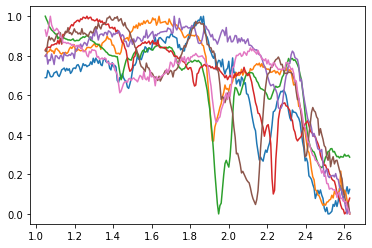

In [73]:
#set the current mineral group being processed
currentMineralGroup='Sulphate'
#create a list to hold sulphate minerals
crismSulphateMinerals=[]
#iterate through all sulphate files
for i,currentSulphateName in zip(sulphateFileIndices,sulphateMineralNames):
    #get the current sulphate files address
    currentFileAddress=micaSpectraDirectory+'/'+allFiles[i]
    #read the current file as a dataframe
    currentSulphateDataframe=pd.read_csv(currentFileAddress,header=None)
    #get the wavelength list
    fullWavelengthList=np.array(currentSulphateDataframe.iloc[:,0])
    #get the ratioed CRISM spectra
    ratioedCorrectedCRISMSpectra=np.array(currentSulphateDataframe.iloc[:,1])
    #subset the wavelength list and spectra to the desired range ie. 1.0-2.6 micron
    subsettedWavelengthList=fullWavelengthList[lowerBoundIndex:upperBoundIndex]
    subsettedRatioedCorrectedCRISMSpectra=ratioedCorrectedCRISMSpectra[lowerBoundIndex:upperBoundIndex]
    #delete the unrequired variables
    del fullWavelengthList
    del ratioedCorrectedCRISMSpectra
    #plot the data
    plt.plot(subsettedWavelengthList,scaleSpectrum(subsettedRatioedCorrectedCRISMSpectra))
    #create an object out of the current spectra
    currentSample=CRISMMICASpectra(currentSulphateName,
                                    currentMineralGroup,
                                    subsettedRatioedCorrectedCRISMSpectra,
                                    subsettedWavelengthList)
    #add the current sulphate mineral to the list of all sulphates
    crismSulphateMinerals.append(currentSample)

In [82]:
#create a list containing names of zeolites and hydrated silicate minerals
zeoliteMineralNames=['prehnite','hydrated_silica','analcime','epidote']
#create a list to hold indices of sulphate mineral files
zeoliteFileIndices=[]
#get indices of each sulphate file
for i in range(len(allFiles)):
    for j in range(len(zeoliteMineralNames)):
        if re.search(zeoliteMineralNames[j],allFiles[i]):
            zeoliteFileIndices.append(i)

G:/CRISM martian spectra/mrocr_8001/data/crism_typespec_analcime.tab
G:/CRISM martian spectra/mrocr_8001/data/crism_typespec_epidote.tab
G:/CRISM martian spectra/mrocr_8001/data/crism_typespec_hydrated_silica.tab
G:/CRISM martian spectra/mrocr_8001/data/crism_typespec_prehnite.tab


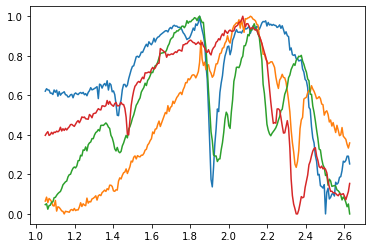

In [83]:
#set the current mineral group being processed
currentMineralGroup='Zeolite & Hydrateds'
#create a list to hold zeolite minerals
crismZeoliteMinerals=[]
#iterate through all sulphate files
for i,currentZeoliteName in zip(zeoliteFileIndices,zeoliteMineralNames):
    #get the current sulphate files address
    currentFileAddress=micaSpectraDirectory+'/'+allFiles[i]
    print(currentFileAddress)
    #read the current file as a dataframe
    currentZeoliteDataframe=pd.read_csv(currentFileAddress,header=None)
    #get the wavelength list
    fullWavelengthList=np.array(currentZeoliteDataframe.iloc[:,0])
    #get the ratioed CRISM spectra
    ratioedCorrectedCRISMSpectra=np.array(currentZeoliteDataframe.iloc[:,1])
    #subset the wavelength list and spectra to the desired range ie. 1.0-2.6 micron
    subsettedWavelengthList=fullWavelengthList[lowerBoundIndex:upperBoundIndex]
    subsettedRatioedCorrectedCRISMSpectra=ratioedCorrectedCRISMSpectra[lowerBoundIndex:upperBoundIndex]
    #delete the unrequired variables
    del fullWavelengthList
    del ratioedCorrectedCRISMSpectra
    #plot the data
    plt.plot(subsettedWavelengthList,scaleSpectrum(subsettedRatioedCorrectedCRISMSpectra))
    #create an object out of the current spectra
    currentSample=CRISMMICASpectra(currentSulphateName,
                                    currentMineralGroup,
                                    subsettedRatioedCorrectedCRISMSpectra,
                                    subsettedWavelengthList)
    #add the current sulphate mineral to the list of all sulphates
    crismZeoliteMinerals.append(currentSample)

In [52]:
#set the names of samples to be used as lab reference for zeolites and hydrated minerals
zeoliteLabSampleNames=['Zeolite/Prehnite LAZE03','Hydrated Si BKR1JB329C','Epidote GDS26','Analcime GDS1']

316

In [84]:
#create a list containing names of sulphate minerals
sulphateMineralNames=['alunite','jarosite','gypsum','bassanite','poly_hyd_sulf','mono_hyd_sulf','hydrox_fe_sulf']
#create a list containing band centres of absorption features for sulphate CRISM spectra
CRISMSulphateBandCentres=[
                            [2.16,2.32,2.45,2.51],
                            [2.27,2.41,2.46,2.52],
                            [2.21,2.26,2.48],
                            [2.26,2.49],
                            [2.43],
                            [2.14,2.4],
                            [2.19,2.23,2.36]
]
#create a list containing band centres of absorption features for sulphate lab spectra
referenceSulphateBandCentres=[
                               [2.17,2.21,2.32,2.43,2.46,2.51],
                               [2.27,2.41,2.46,2.52],
                               [2.22,2.27,2.48],
                               [2.26,2.48],
                               [2.42],
                               [2.14,2.4],
                               [2.19,2.23,2.37]
]

In [85]:
#create a list containing names of zeolites and hydrated silicate minerals
zeoliteMineralNames=['prehnite','hydrated_silica','analcime','epidote']
#create a list containing band centres of absorption features for zeolite CRISM spectra
CRISMZeoliteBandCentres=[
                            [2.35,2.47,2.52],
                            [2.21],
                            [2.52],
                            [2.26,2.35],
]
#create a list containing band centres of absorption features for zeolite reference spectra
referenceZeoliteBandCentres=[
                            [2.36,2.48,2.53],
                            [2.21],
                            [2.13,2.54],
                            [2.25,2.33],
]